In [1]:
rm(list = ls())

## PCA

In [2]:
library(patchwork)

In [3]:
library(reshape2)
df_TPM<- read.table("./02_result/Expression_TPM.tsv", header = T, sep = "\t", row.names = 1)
df_phe <- read.table("./00_metadata/group.csv", header = T, sep = ",")

# df_phe$Sample 转化为 factor
df_phe$Sample <- factor(df_phe$Sample, levels = df_phe$Sample)
df_phe$SRR_ID <- as.factor(df_phe$SRR_ID)
df_phe$Group <- as.factor(df_phe$Group)

In [4]:
df_pca <- t(df_TPM)
df_pca <- df_pca[, which(apply(df_pca, 2, var) != 0)]
pca <- prcomp(
    df_pca, # 为什么需要转置——PCA的输入：列是特征，行是样本。
    center = TRUE,
    scale = TRUE # 为什么需要转置——PCA的输入：列是特征，行是样本。
)
pca.data <- data.frame(pca$x)
pca.variance <- pca$sdev^2 / sum(pca$sdev^2)

pcaPlotDat <- cbind(df_phe, pca$x[, 1:3])
pcaPlotDat$SRR_ID <- as.factor(pcaPlotDat$SRR_ID)
pcaPlotDat$Group <- as.factor(pcaPlotDat$Group)
pcaPlotDat

,SRR_ID,Sample,Group,PC1,PC2,PC3
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
Ctrl_18M_A,SRR10123774,Ctrl_18M_A,Ctrl,-93.53651,124.803377,-24.40471
Ctrl_18M_B,SRR10123775,Ctrl_18M_B,Ctrl,-71.95063,-84.049850,13.09857
Ctrl_18M_C,SRR10123776,Ctrl_18M_C,Ctrl,-85.54720,-40.332836,50.07251
MCAO_18M_A,SRR10123786,MCAO_18M_A,MCAO,67.60367,-39.477299,-88.52191
MCAO_18M_B,SRR10123787,MCAO_18M_B,MCAO,51.45789,3.846823,-29.32763
MCAO_18M_C,SRR10123788,MCAO_18M_C,MCAO,131.97278,35.209785,79.08317


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


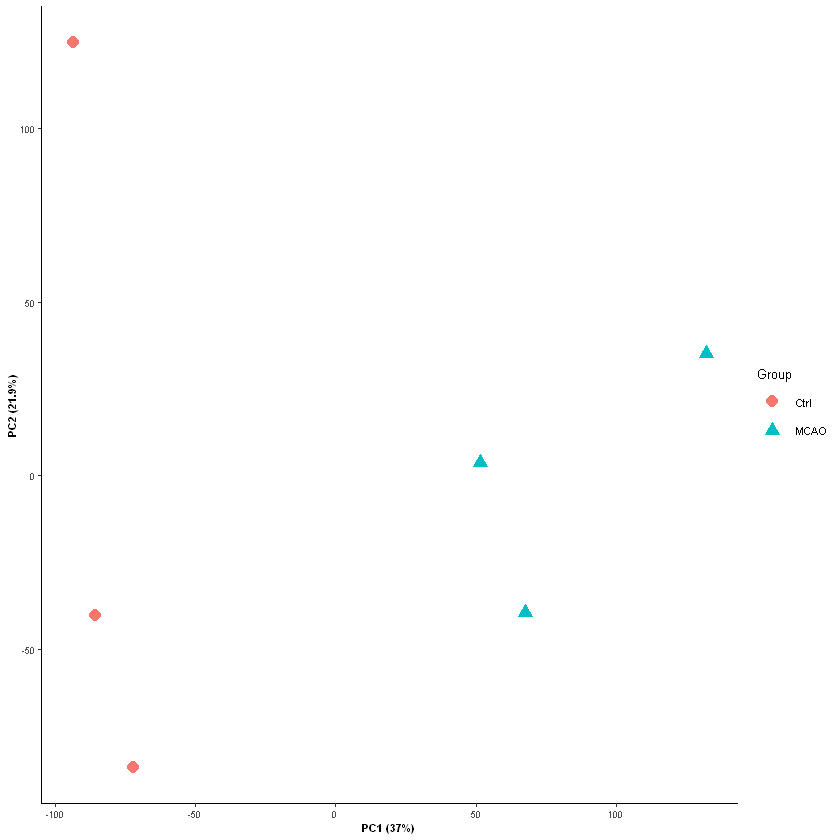

In [5]:
library("ggplot2")
p_PCA <- ggplot(pcaPlotDat) +
    theme_classic(8) +
    geom_point(aes(x = PC1, y = PC2, shape = Group, color = Group), size = 3) +
    xlab(paste("PC1 (", round(pca.variance[1] * 100, 1), "%)", sep = "")) +
    ylab(paste("PC2 (", round(pca.variance[2] * 100, 1), "%)", sep = "")) +
    # stat_ellipse(aes(x = PC1, y = PC2, color = Group),level = 0.95, show.legend = F) +
    theme(
            plot.title = element_text(hjust = 0.5, size = rel(1), face = "bold"),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.text = element_text(size = rel(1), face = "bold"),
            strip.background = element_blank(),
            axis.text.x = element_text(size = rel(0.8), angle = 0),
            axis.text.y = element_text(size = rel(0.8), angle = 0),
            axis.title = element_text(size = rel(0.8), face = "bold"),
            axis.line = element_line(colour = "black", size = rel(0.7), linetype = "solid")
        )
p_PCA
ggsave(p_PCA, filename = "./03_analysis/PCA.pdf", width = 4, height = 3)

In [6]:

library("dendextend")
tree_corD <- hclust(as.dist(1 - cor(t(pca$x[, 1:6]))))
dend <- as.dendrogram(tree_corD)
pdf("./03_analysis/hclust.pdf", 7.5, 6)
dend %>%
    set("labels_col", value = c("#44af8f", "#d95f02"), k = 2) %>%
    plot(main = "Cluster Dendrogram")

dev.off()


---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: 'dendextend'


The following object is masked from 'package:stats':

    cutree




png 
  2

## Differential expression

In [7]:
gene_exp <- read.table("./02_result/gene_exp.diff", header = T)
gene_exp <- gene_exp[, c(2, 3, 10, 12, 13)]
gene_exp <- gene_exp[is.finite(gene_exp$log2.fold_change.), ]

# add sig column: Up, Down, Nosig
gene_exp$Sig <- "Nosig"
gene_exp$Sig[gene_exp$p_value < 0.05 & gene_exp$log2.fold_change. > 1] <- "Up"
gene_exp$Sig[gene_exp$p_value < 0.05 & gene_exp$log2.fold_change. < -1] <- "Down"
gene_exp$Sig <- factor(gene_exp$Sig, levels = c("Up", "Nosig", "Down"))

table(gene_exp$Sig)



   Up Nosig  Down 
 1290 42004   261 

In [8]:
# select DEG
DEG <- gene_exp[gene_exp$Sig != "Nosig", ]
DEG <- DEG[order(abs(DEG$log2.fold_change.), decreasing = T), ] # sort by log2FC
write.table(DEG, file = "./03_analysis/DiffGenes_FC2.csv ", sep = ",", quote = F, row.names = F)

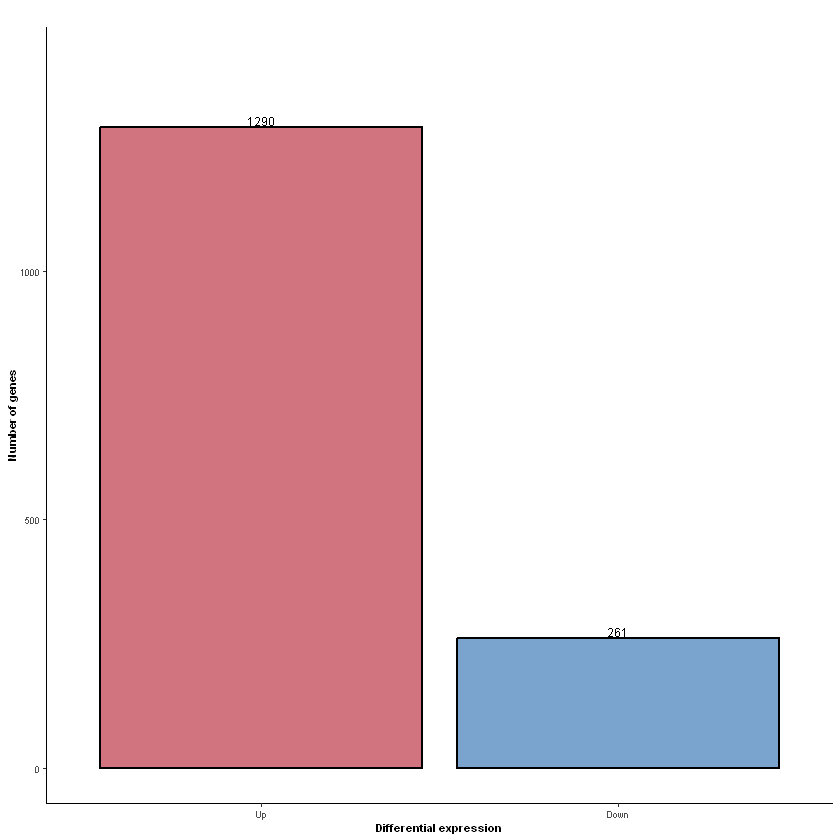

In [20]:
# plot barplot
library(ggrepel)
library(ggplot2)
tab <- as.data.frame(table(DEG$Sig))
tab <- tab[tab$Var1 != "Nosig", ]


tab$Var1 <- factor(tab$Var1, levels = c("Up", "Down"))

p <- ggplot(tab, aes(x = Var1, y = Freq, label = Freq, fill = Var1)) +
    geom_bar(stat = "identity", color = "black", size = 0.7) +
    geom_text(position = position_dodge(0.9), vjust = -0.2, size = 2.5) +
    ylim(0, max(tab$Freq) * 1.1) +
    theme_classic(8) +
    xlab("Differential expression") +
    ylab("Number of genes") +
    ggtitle("") +
    theme(legend.position = "none") +
    scale_fill_manual(values = c("#b2182b99", "#2166ac99")) +
    theme(
            plot.title = element_text(hjust = 0.5, size = rel(1), face = "bold"),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.text = element_text(size = rel(1), face = "bold"),
            strip.background = element_blank(),
            axis.text.x = element_text(size = rel(0.8), angle = 0),
            axis.text.y = element_text(size = rel(0.8), angle = 0),
            axis.title = element_text(size = rel(0.8), face = "bold"),
            axis.line = element_line(colour = "black", size = rel(0.7), linetype = "solid")
        )

# 柱状图添加深色边框

p
ggsave(p, filename = "./03_analysis/diffgene_number_barplot.pdf", width =4, height = 4)

## Volcano plot

Warning message:
"Removed 59 rows containing missing values (`geom_point()`)."


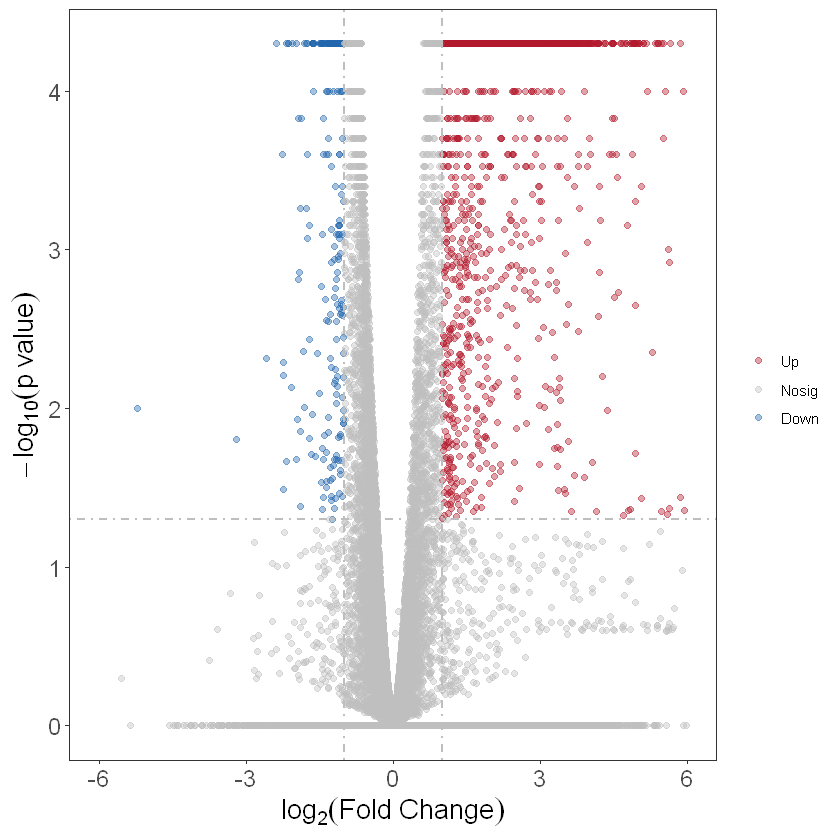

In [10]:

# 根据上调、下调、不变为基因添加颜色信息

color <- c(Up = "#b2182b", Nosig = "grey", Down = "#2166ac")

p <- ggplot(gene_exp, aes(log2.fold_change., -log10(p_value), color = Sig)
) +
    geom_point(alpha = 0.4 ) +
        theme_bw() +
        scale_color_manual(values = color) +
        # 辅助线
        geom_hline(yintercept = -log10(0.05), lty = 4, col = "grey", lwd = 0.6) +
        geom_vline(xintercept = c(-1, 1), lty = 4, col = "grey", lwd = 0.6) +
        xlim(-6, 6) +
        ylab(expression(-log[10](p~value))) +
        xlab(expression(log[2](Fold~Change))) +
        # 图例
        theme(
            legend.position = "right",
            panel.grid = element_blank(),
            axis.title = element_text(size = 16),
            axis.text = element_text(size = 14)
        )+theme(legend.title = element_blank())
    p





In [11]:
# 依次按照padjust值log2fc.DSS_NG.Ctrl_NG.值进行排序
library(dplyr)
selected_genes <- c(
    "Stat1", "Irf9", "Oas3", "Usp18", "Ddx58", "Isg15", "Ifi203",  "Ifit2","Ifi44","Cd300If",
    "Nefh", "Rorb", "Nefm", "Cplx1", "Syt2","Chrm2","Kcnc1","Kcnc3","Kcnip2","Shroom2","Atg9a","Chtf18","Etnppl"
)
selected_genes <- gene_exp[gene_exp$gene %in% selected_genes, ]

# 筛选出selected_genes





Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Warning message:
"Removed 59 rows containing missing values (`geom_point()`)."
Warning message:
"ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


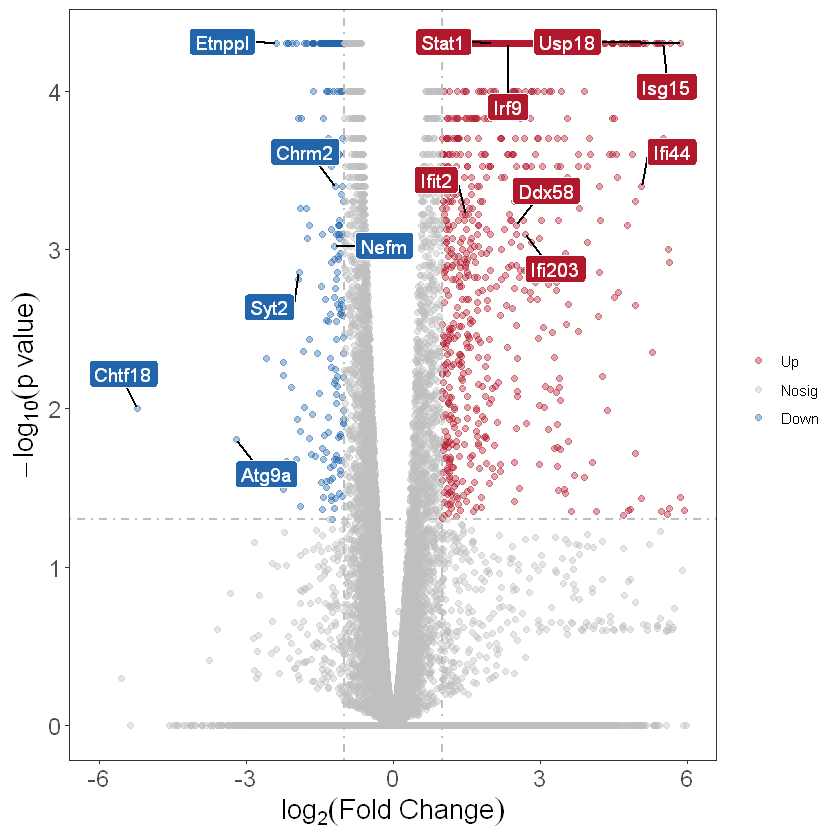

In [12]:


p_topn <- p + geom_label_repel(
    data = selected_genes,
    aes(log2.fold_change.,  -log10(p_value), label = gene,fill=Sig),
    color = "white",
    size = 4, # font size
    box.padding = 0.8, # font to point distance
    segment.colour = "black",
    segment.size=0.7, # line width
    min.segment.length = 0, # min line length
    show.legend = FALSE,
)+ scale_fill_manual(values=c("#b2182b",  "#2166ac"))
p_topn


In [13]:
ggsave(p_topn, filename = "./03_analysis/diffgene_volcano.pdf", width = 6, height = 6)

Warning message:
"Removed 59 rows containing missing values (`geom_point()`)."
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


## 层次聚类



In [14]:
# 筛选top 50的基因进行层次聚类
library(dplyr)
library(gplots)

selected_up <- DEG[DEG$Sig == "Up", ][1:40, ]
selected_down <- DEG[DEG$Sig == "Down", ][1:20, ]
selected_DEG <- rbind(selected_up, selected_down) -> selected_genes


# 根据top50的gene_id 筛选出df_TPM 所在的行
sigGeneDat <- df_TPM[selected_DEG$gene_id, ]
rownames(sigGeneDat) <- selected_DEG$gene


periodCols <- c("#44af8f", "#d95f02")
names(periodCols) <- levels(df_phe$Group)
periodColors <- periodCols[as.character(df_phe$Group)]

rowHClust <- hclust(as.dist(1 - cor(t(sigGeneDat))))
rowTree <- as.dendrogram(rowHClust)

# cutree from hierarchical clustering
gClust <- cutree(rowHClust, k = 2) # 根据先前运行结果选择聚类为2类
# 选择基因分类的颜色



Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess




In [15]:


pdf("./03_analysis/diffgene_heatmap.pdf", 6, 12)
heatmap.2(as.matrix(sigGeneDat), Rowv = rowTree, dendrogram = "both", scale = "row", trace = "none", col = redgreen(75), ColSideColors = periodColors, margins = c(8, 10), lhei = c(1, 9))
dev.off()

png 
  2

# GO&KEGG

In [29]:
rownames(df_TPM) <- gsub("\\..*", "", rownames(df_TPM))
rownames(DEG) <- gsub("\\..*", "", DEG$gene_id)
DEG_up <- DEG[DEG$Sig == "Up", ]
DEG_down <- DEG[DEG$Sig == "Down", ]



In [17]:
library(clusterProfiler)
library(org.Mm.eg.db)
library(cowplot)
keytypes(org.Mm.eg.db)


# gene id translaste to ENTREZID
DEG_up_gene <- bitr(rownames(DEG_up),
fromType = "ENSEMBL",
toType = "ENTREZID",
OrgDb = org.Mm.eg.db
) 

DEG_down_gene <- bitr(rownames(DEG_down),
fromType = "ENSEMBL",
toType = "ENTREZID",
OrgDb = org.Mm.eg.db
)

geneList <- bitr(rownames(df_TPM),
fromType = "ENSEMBL",
toType = "ENTREZID",
OrgDb = org.Mm.eg.db
) 





clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, F

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(DEG_up), fromType = "ENSEMBL", toType = "ENTREZID", :
"3.26% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(DEG_down), fromType = "ENSEMBL", toType = "ENTREZID", :
"11.88% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(df_TPM), fromType = "ENSEMBL", toType = "ENTREZID", :
"36.9% of input gene IDs are fail to map..."


In [50]:

# 对样本间的差异基因进行GO富集分析
DEG_up_go <- enrichGO(
    gene = DEG_up_gene$ENTREZID,
    universe = names(geneList$ENTREZID),
    OrgDb = org.Mm.eg.db,
    ont = "BP", # BP: biological process, MF: molecular function, CC: cellular component
    pAdjustMethod = "BH",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05,
    readable = TRUE
)

DEG_up_go_read <- DOSE::setReadable(DEG_up_go,
    OrgDb = "org.Mm.eg.db",
    keyType = "ENTREZID"
) # ENTREZID to gene Symbol
write.csv(DEG_up_go_read@result, "./03_analysis/GO_DEG_up_enrichresults.csv")



DEG_down_go <- enrichGO(
    gene = DEG_down_gene$ENTREZID,
    universe = names(geneList$ENTREZID),
    OrgDb = org.Mm.eg.db,
    ont = "BP", # BP: biological process, MF: molecular function, CC: cellular component
    pAdjustMethod = "BH",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.05,
    readable = TRUE
)


DEG_down_go_read <- DOSE::setReadable(DEG_down_go,
    OrgDb = "org.Mm.eg.db",
    keyType = "ENTREZID"
) # ENTREZID to gene Symbol
write.csv(DEG_down_go_read@result, "./03_analysis/GO_DEG_down_enrichresults.csv")



In [55]:
p1 <- dotplot(DEG_up_go, showCategory = 10) + ggtitle("Downregulated")
p2 <- dotplot(DEG_down_go, showCategory = 10) + ggtitle("Upregulated")
pp <- plot_grid(p1, p2, ncol = 2, labels = LETTERS[1:2])
ggsave(pp, filename = "./03_analysis/GO_dotplot.pdf", width = 12, height = 10)


In [56]:




pp_go_cnetplot <- cnetplot(DEG_up_go,
    showCategory = 6, colorEdge = T,
    node_label = "all",
    color_category = "steelblue"
)
pp_down_cnetplot <- cnetplot(DEG_down_go,
    showCategory = 6, colorEdge = T,
    node_label = "all",
    color_category = "steelblue"
)

pp_cnetplot <- plot_grid(pp_go_cnetplot, pp_down_cnetplot, ncol = 2, labels = LETTERS[1:4])

ggsave(pp_cnetplot, filename = "./03_analysis/GO_cnetplot.pdf", width = 24, height = 10)

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version."
Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(category = your_value)' instead of 'color_category'.
 The color_category parameter will be removed in the next version."
Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version."
Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(category = your_value)' instead of 'color_category'.
 The color_category parameter will be removed in the next version."
Warning message:
"ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [47]:
library(enrichplot)
DEG_up_go_pair <- pairwise_termsim(DEG_up_go)
pp_go_emapplot <- emapplot(DEG_up_go_pair)
DEG_down_go_pair <- pairwise_termsim(DEG_down_go)
pp_down_emapplot <- emapplot(DEG_down_go_pair)

pp_emapplot<-plot_grid(pp_go_emapplot, pp_down_emapplot, ncol = 2, labels = LETTERS[1:2])

ggsave(pp_emapplot, filename = "./03_analysis/GO_emapplot.pdf", width = 24, height = 10)


In [58]:


pp_go_goplot <- goplot(DEG_up_go)
pp_down_goplot <- goplot(DEG_down_go)

pp_goplot <- plot_grid(pp_go_goplot, pp_down_goplot, ncol = 2, labels = LETTERS[1:2])

ggsave(pp_goplot, filename = "./03_analysis/GO_goplot.pdf", width = 24, height = 10)

Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [62]:
# 对样本间的差异基因进行KEGG富集分析
DEG_up_kk <- enrichKEGG(
    gene = DEG_up_gene$ENTREZID,
    organism = "mmu",
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    qvalueCutoff = 0.05
)

DEG_down_kk <- enrichKEGG(
    gene = DEG_down_gene$ENTREZID,
    organism = "mmu",
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    qvalueCutoff = 0.05
)

p_dotplot_up_kk <- dotplot(DEG_up_kk, showCategory = 10) + ggtitle("DFC KEGG enrichment")
p_dotplot_down_kk <- dotplot(DEG_down_kk, showCategory = 10) + ggtitle("CBC KEGG enrichtment")
pp2 <- plot_grid(p_dotplot_up_kk, p_dotplot_down_kk, ncol = 2, labels = LETTERS[1:2])
ggsave(pp2, filename = "./03_analysis/KEGG_dotplot.pdf", width = 11, height = 7)